In [1]:
import numpy as np
from tqdm import trange, tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import scipy.stats as ss

import torch
import torch.nn as nn

In [2]:
np.random.seed(41310)
torch.manual_seed(41310)

In [3]:
class feature_dist:
    """
    Just a little class to wrap the behaviour of the distributions over
    features. Defines a Gaussian distribution, allows for pdf evaluation
    and sampling.
    """

    def __init__(self, mean=0, sd=1):
        self.mean = mean
        self.sd = sd

    def pdf(self, x):
        return ss.norm.pdf(x, loc=self.mean, scale=self.sd)

    def sample(self, num):
        return np.random.normal(loc=self.mean, scale=self.sd, size=(num, 1))

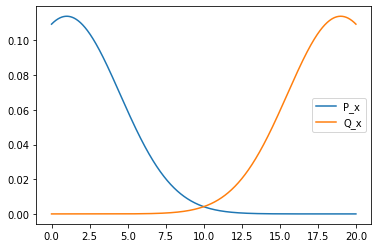

In [4]:
P_x = feature_dist(1, 3.5)
Q_x = feature_dist(19, 3.5)

x = np.linspace(0, 20, 1000)

pdf_p = P_x.pdf(x)
pdf_q = Q_x.pdf(x)

plt.plot(x, pdf_p, label="P_x")
plt.plot(x, pdf_q, label="Q_x")
plt.legend()
plt.show()

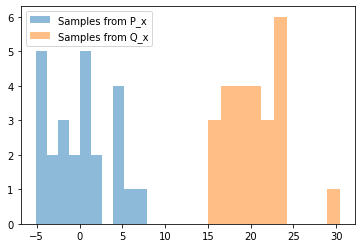

In [5]:
num_samples = 25

samples_p = P_x.sample(num_samples)
samples_q = Q_x.sample(num_samples)

plt.hist(samples_p, alpha=0.5, label="Samples from P_x")
plt.hist(samples_q, alpha=0.5, label="Samples from Q_x")
plt.legend()
plt.show()

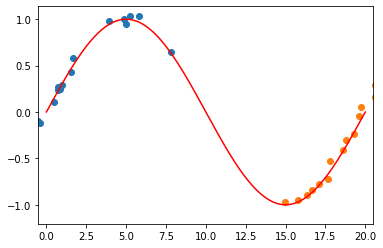

In [6]:
def y_target(x):
    # return np.sin(x)/2 + x/4 - x**2/100
    x = x / 20
    return np.sin(2 * np.pi * x)  # + 0.3*np.sin(4*np.pi*x)


def y_noise(n, sd):
    return np.random.normal(loc=0, scale=sd, size=(n, 1))


y_samples_p = y_target(samples_p) + y_noise(num_samples, 0.05)
y_samples_q = y_target(samples_q) + y_noise(num_samples, 0.05)
true_func = y_target(x)

plt.scatter(samples_p, y_samples_p, label="P_x")
plt.scatter(samples_q, y_samples_q, label="Q_x")

plt.plot(x, true_func, c="r", label="True function")
plt.xlim(-0.5, 20.5)

# plt.legend()
plt.show()

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 12),
            nn.Tanh(),
            # nn.Linear(12, 12),
            # nn.Tanh(),
            nn.Linear(12, 1),
        )

    def forward(self, x):

        return self.linear_relu_stack(x)

    def loss(self, features, targets):

        return ((self.forward(features) - targets) ** 2).sum()

    def train(self, features, targets, iters=500, l_rate=1e-3):

        optimizer = torch.optim.Adam(self.parameters(), lr=l_rate, betas=[0.1, 0.01])

        for it in tqdm_notebook(range(iters)):

            optimizer.zero_grad()
            loss = self.loss(features, targets)
            loss.backward()
            optimizer.step()
        print(loss)
        return

In [8]:
p_train = torch.tensor(samples_p).float()
p_target = torch.tensor(y_samples_p).float()

q_train = torch.tensor(samples_q).float()
q_target = torch.tensor(y_samples_q).float()

In [9]:
model1 = NeuralNetwork()
model1.train(p_train, p_target, iters=20000, l_rate=1e-4)

model2 = NeuralNetwork()
model2.train(q_train, q_target, iters=30000, l_rate=1e-4)

/var/folders/wp/py0z2l9105vbrwd4qfhyphlr0000gn/T/ipykernel_28788/1489549808.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(iters)):


  0%|          | 0/20000 [00:00<?, ?it/s]

tensor(0.0401, grad_fn=<SumBackward0>)


  0%|          | 0/30000 [00:00<?, ?it/s]

tensor(0.8400, grad_fn=<SumBackward0>)


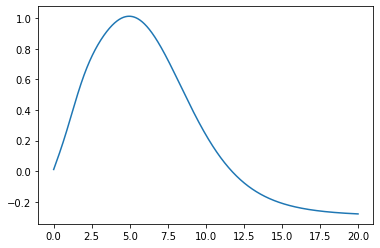

In [10]:
plt.plot(x, model1.forward(torch.tensor(x).float().reshape((1000, 1))).detach())

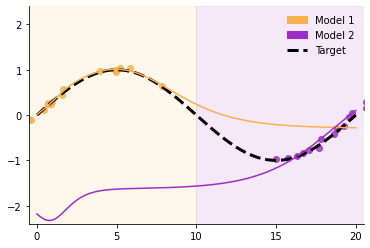

In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

CB91_Blue = "#2CBDFE"
CB91_Green = "#47DBCD"
CB91_Pink = "#F3A0F2"
CB91_Purple = "#9D2EC5"
CB91_Violet = "#661D98"
CB91_Amber = "#F5B14C"


plt.scatter(samples_p, y_samples_p, c=CB91_Amber, label="P_x", alpha=0.8)
plt.scatter(samples_q, y_samples_q, c=CB91_Purple, label="Q_x", alpha=0.8)

plt.plot(x, true_func, c="black", label="True function", linewidth=3.0, linestyle="--")

x_torch = torch.tensor(x).float().reshape((1000, 1))

plt.plot(
    x,
    model1.forward(x_torch).detach(),
    c=CB91_Amber,
)
plt.plot(
    x,
    model2.forward(x_torch).detach(),
    c=CB91_Purple,
)

# plt.hist(samples_p, alpha = 0.5, label = 'Samples from P_x')
# plt.hist(samples_q, alpha = 0.5, label = 'Samples from Q_x')

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvspan(-5, 10, color=CB91_Amber, alpha=0.1)
plt.axvspan(10, 25, color=CB91_Purple, alpha=0.1)

plt.xlim(-0.5, 20.5)
plt.ylim(-2.4, 2.4)

plt.xticks([0, 5, 10, 15, 20])
plt.yticks([-2, -1, 0, 1, 2])

model1_patch = mpatches.Patch(color=CB91_Amber, label="Model 1")
model2_patch = mpatches.Patch(color=CB91_Purple, label="Model 2")
black_line = mlines.Line2D(
    [], [], color="black", linewidth=3.0, linestyle="--", label="Target"
)

plt.legend(frameon=False, handles=[model1_patch, model2_patch, black_line])
plt.show()

In [12]:
model2.loss(q_train, q_target)

tensor(0.8399, grad_fn=<SumBackward0>)

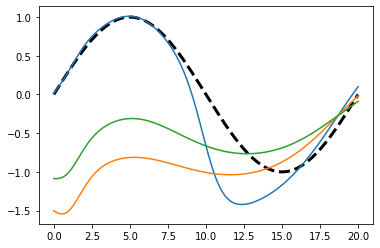

In [13]:
pred_p = model1.forward(torch.tensor(x).float().reshape((1000, 1))).detach()
pred_q = model2.forward(torch.tensor(x).float().reshape((1000, 1))).detach()
w_p = pdf_p / (pdf_p + pdf_q)
w_q = pdf_q / (pdf_p + pdf_q)

l_p = np.exp(model1.loss(p_train, p_target).detach())
l_q = np.exp(model2.loss(q_train, q_target).detach())

bma_w_p = l_p / (l_p + l_q)
bma_w_q = l_q / (l_p + l_q)

total_weight = pdf_p + pdf_q

pred = (pred_p.squeeze() * w_p) + (pred_q.squeeze() * w_q)
pred.shape

naive_pred = (pred_p * 0.5) + (pred_q * 0.5)
bma_pred = (pred_p.squeeze() * bma_w_p) + (pred_q.squeeze() * bma_w_q)


plt.plot(x, true_func, c="black", label="True function", linewidth=3.0, linestyle="--")
plt.plot(x, pred)
plt.plot(x, bma_pred)
plt.plot(x, naive_pred)

In [14]:
len(total_weight)

1000

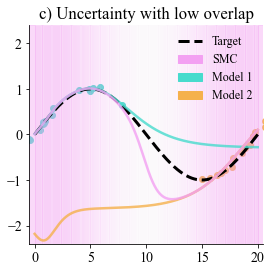

In [17]:
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.serif"] = "Times New Roman"
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 14

# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# matplotlib.rcParams['font.family'] = "sans-serif"

fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

ax1.scatter(samples_p, y_samples_p, c=CB91_Green, label="P_x", alpha=0.9)
ax1.scatter(samples_q, y_samples_q, c=CB91_Amber, label="Q_x", alpha=0.9)

ax1.plot(x, true_func, c="black", label="True function", linewidth=3.0, linestyle="--")
ax1.plot(x, model1.forward(x_torch).detach(), c=CB91_Green, linewidth=2.5, alpha=0.8)
ax1.plot(x, model2.forward(x_torch).detach(), c=CB91_Amber, linewidth=2.5, alpha=0.8)
ax1.plot(x, pred, c=CB91_Pink, label="SMC", linewidth=2.5, alpha=0.8)

# ax1.axvspan(-5, 10, color=CB91_Green, alpha=0.1)
# ax1.axvspan(10, 25, color=CB91_Amber, alpha=0.1)

max_weight = 0.2
total_weight = (total_weight / max(total_weight)) * max_weight

N = 200
from_x = [i * 0.1 for i in range(N)]
to_x = [(i * 0.1) + 0.12 for i in range(N)]
for i in range(N):
    den = total_weight[int((i * (np.ceil(1000 / N))))]
    ax1.axvspan(from_x[i], to_x[i], color=CB91_Pink, alpha=den)

ax1.axvspan(-5, 0, color=CB91_Pink, alpha=0.4)
ax1.axvspan(20, 25, color=CB91_Pink, alpha=0.4)

"""
N = 200

from_x = np.linspace(0,19.9,N)
to_x = from_x + 0.1

for i in range(N):
    ri = float(i)/float(N)
    gi = 1.-ri
    bi = 0.

    ax1.axvspan(from_x[i], to_x[i], color=CB91_Green, alpha=den)
"""

model1_patch = mpatches.Patch(color=CB91_Green, label="Model 1")
model2_patch = mpatches.Patch(color=CB91_Amber, label="Model 2")
black_line = mlines.Line2D(
    [], [], color="black", linewidth=3.0, linestyle="--", label="Target"
)
scm_patch = mpatches.Patch(color=CB91_Pink, label="SMC")
ax1.legend(
    frameon=False,
    handles=[black_line, scm_patch, model1_patch, model2_patch],
    fontsize=12,
)

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.title.set_text("c) Uncertainty with low overlap")

plt.setp(
    (ax1),
    xlim=(-0.5, 20.5),
    ylim=(-2.4, 2.4),
    xticks=[0, 5, 10, 15, 20],
    yticks=[-2, -1, 0, 1, 2],
)

plt.tight_layout()
plt.savefig("uncertainty_low_overlap.pdf")
plt.show()